#### CMSE 202 Final Project
### &#9989; Chris Brown, Kewalin Samart, Jay Scott, Raymond Smith
### &#9989; Section_003
#### &#9989; 4/13/21

# ___Modeling Oxygen Repopulation in Blood Cells___

## Background and Motivation

Adenosine Triphosphate (ATP) is the main compound in our body that the cells use to store and release energy. Oxygen is essential for ATP production in the Krebs cycle. Without oxygen, our body cannot make any energy, and insufficient oxygen intake reduces metabolism efficiency. In the respiratory process, we take in oxygen and take out unnecessary gases e.g. carbon dioxide, by breathing. About 97% of the oxygen is transported throughout the body by hemoglobins in the red blood cells, and the rest is dissolved in plasma. One hemoglobin has a minimum capacity of one oxygen molecule and a maximum capacity of four oxygen molecules. Hemoglobins carry oxygen molecules and drop them off at the target cells in organ tissues. As a waste of the Krebs cycle, carbon dioxide is picked up by the hemoglobin and transported to the lung in order to be released through the gas exchange process. To obtain a better understanding of this important biological mechanism. We, therefore, develop an agent-based model to demonstrate how blood cells repopulate oxygen in the body. The model focuses on showing the big picture of how red blood cells as carriers of oxygen and carbon dioxide move around the body through veins and arteries.

## Methodology

In [1]:
import numpy as np
import pandas as pd
import math
import random
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Pseudocode

__*Focusing on modeling blood moving through veins/arteries. Possibly model a smaller process, oxygen from lungs to blood*__

1) Initialize a board- Put oxygen, blood cells, and organs on the board. Veins/arteries represented by straight line boundaries on board. Put veins and arteries on the board with junctions. Organs should occupy multiple grid points and be initialized containing CO2

2) Use classes to represent oxygen, blood cell/hemoglobin, and organs.

    Attributes/Methods
    
    Oxygen; Able to be transferred from blood to organs. (For smaller model)Oxygen is able to diffuse from lungs to blood stream. Oxygen randomly appears every few time steps to represent breathing. Most oxygen must be carried by blood cells/hemoglobin. A percentage of oxygen dissolves/diffuses into plasma which contains blood cells. 3% of oxygen will be randomly chosen to move randomly through plasma alongside blood cells.
    
    Blood Cells/Hemoglobin; Randomly assign blood cells at start to have oxygen or CO2. Blood cells have two different states, full of oxygen and full of CO2. Moves radomly through veins and arteries, at junctions we can set different probabilities for which path a blood cell might take. Blood cells check every grid point around them (nearest neighbor function) for vein/artery paths. Blood cells carrying CO2 only travel through veins and cells carrying oxygen only travel through arteries.
    
    Organs; Organs contain CO2 when initialized with the board. Absorb oxygen and create CO2. When oxygen reaches an organ it is turned into CO2 and leaves the organ. When CO2 reaches the lungs we somehow show it being expelled from the body (it disappears from the model)



### Actual Code

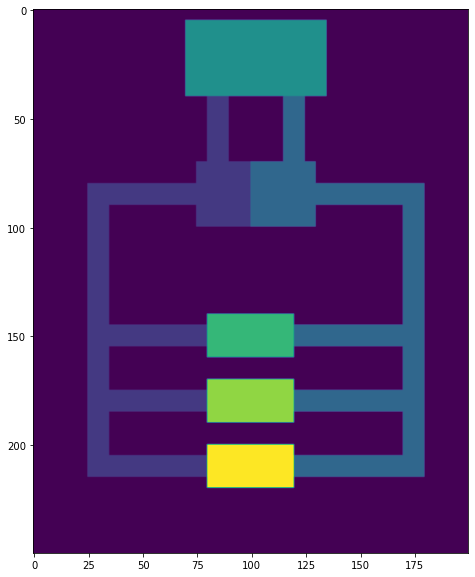

In [2]:
board = np.zeros(shape = (250,200)) # Initializing a 250 by 200 size board of color purple

# heart
board[70:100,75:100] = 1 # left part of the heart (low oxygen; blue)
board[70:100,100:130] = 2 # right part of the heart (high oxygen; teal; anatomically bigger than the left part)

# lung 
board[5:40,70:135] = 3

# organ no.1 
board[140:160,80:120] = 4

# organ no.2
board[170:190,80:120] = 5

# organ no.3
board[200:220,80:120] = 6

# veins; blue
board[40:70,80:90] = 1 # vein connecting lung and left part of the heart
board[80:90,25:75] = 1 # top vein connecting lung with organs
board[90:215,25:35] = 1 # side vein connecting lung with organs
board[145:155,35:80] = 1 # side vein organ no.1
board[175:185,35:80] = 1 # side vein organ no.2
board[205:215,35:80] = 1 # side vein organ no.3

# arteries; teal
board[40:70,115:125] = 2 # artery connecting lung and right part of the heart
board[80:90,130:180] = 2 # top artery connecting lung with organs
board[90:215,170:180] = 2 # side artery connecting lung with organs
board[145:155,120:170] = 2 # side artery organ no.1
board[175:185,120:170] = 2 # side artery organ no.2
board[205:215,120:170] = 2 # side artery organ no.3

# plotting the board
plt.figure(figsize=(20,10))
plt.imshow(board) 

In [10]:
def getNeighborValues(i,j, board):
    # The following list contains the indices of the neighbors for a pixel at (i.j)
    neighborhood = [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]
    
    neighbor_values = []
    for neighbor in neighborhood:
        if onBoard(neighbor[0], neighbor[1], board) == True:
            neighbor_values.append(board[neighbor[0],neighbor[1]])
    return neighbor_values


class blood_cell():
    '''
    This is the blood cells class and it allows the blood cells to move around as well as absorb oxygen and carbon dioxide.
    '''
    
    def __init__(self, x_dims, y_dims, shape='round', color = 'red'): #We could change the shape attribute to an oxygen capacity attribute
        self.shape = shape
        #self.molecule = molecule
        self.x = x_dims
        self.y = y_dims
        
        if self.shape == 'round':
            oxygen_cap = 6
            carbon_cap = 5
        elif self.shape == 'sickle':
            oxygen_cap = 3
            carbon_cap = 2
        
        self.oxygen_cap = oxygen_cap
        self.carbon_cap = carbon_cap
        
        self.color = color 
        
        b_x = self.x 
        b_y = self.y
        
    def transfer(self):
        # Determine if blood cell is in lungs using nearest neighbor, if it is then it picks up the maximum amount of oxygen and releases
        # CO2
      
        # Determine if blood cell is in an organ using nearest neighbor, if it is then it picks up the max amount of CO2 and releases
        # oxygen
        #neighbors = getNeighborValues(self.x_dim, self.y_dim, board)
        if 70 < self.x < 135 and 5 < self.y < 40:
            #ox_supply = self.oxygen_cap
            #carb_supply = 0
            color = 'red'
        elif 80 < self.x < 120 and ((140 < self.y < 160) or (170 < self.y < 190 ) or (200 < self.y < 220)):
            #ox_supply = 0
            #carb_supply = self.carbon_cap
            color = 'blue'
            
        self.color = color
        
    def draw(self):
         
        plt.scatter(self.x, self.y, c=self.color)

    
    def movement_down(self):
        
        '''
        Oxygen moves through the arteries towards organs
        This is shown through the oxygen object moving 1 unit downwards
        '''
        b_dy = 1
        
        b_x = self.x 
        b_y = self.y + b_dy 
        
        self.x = b_x #oxygen coordinates update after it moves 
        self.y = b_y   
        
    def movement_right(self):
        
        '''
        Oxygen moves through the arteries towards organs  
        This is shown through the oxygen object moving 1 unit to the right 
        '''
        
        b_dx = 1 
        
        b_x = self.x + b_dx
        b_y = self.y 
        
        self.x = b_x #oxygen coordinates update after it moves 
        self.y = b_y      
        
    def movement_left(self):
        
        '''
        Oxygen moves through the arteries towards organs 
        This is shown through the oxygen object moving 1 unit to the left 
        '''
        
        b_dx = 1
        
        b_x = self.x - b_dx
        b_y = self.y 
        
        self.x = b_x #oxygen coordinates update after it moves 
        self.y = b_y  
        
    def board_location(self):
        
        '''
        Provides the current location of the oxygen object on the board
        '''
        
        return self.x, self.y
    
    def distance (self, organ_locationx, organ_locationy): 
        
        '''
        Provides distance between oxygen object and inputed organ location
        '''
    
        distance = ((organ_locationx - self.x)**2) + ((organ_locationy - self.y)**2) 
        #distance formula, using organ and current oxygen molecule location 
        return distance




In [39]:
class oxygen():
    
    def __init__ (self, artery_locationx = 120, artery_locationy = 40):
        
        '''
        Intializing the oxygen object and its location 
        '''
        
        self.x = artery_locationx #location to be drawn 
        self.y = artery_locationy #location to be drawn 
    
        o_x = self.x 
        o_y = self.y
        on_board = 0 
        self.on_board = on_board
        
    def enter_blood(self):
        
        '''
        3% of Oxygen is diffused/dissolved into plasma within blood 
        This is shown through an oxygen object being drawn within the arteries
        '''
        
        param = 1 
        prob = random.random()
        if prob > 0.97:
            
            #plt.scatter(self.x, self.y, c='aqua') #plots blue marker 'oxygen' on board at artery location
            self.on_board = param 
            
    def draw(self):
        
        '''
        Draws the oxygen object on the board 
        '''
        if self.on_board == 1:
            plt.scatter(self.x, self.y, c='aqua')
        else:
            pass 
        
    def movement_up(self):
        
        '''
        Oxygen moves through the arteries towards the heart and the lung
        This is shown through the oxygen object moving 1 unit upwards
        '''
        o_dy = 1
        
        o_x = self.x 
        o_y = self.y - o_dy 
        
        self.x = o_x #oxygen coordinates update after it moves 
        self.y = o_y   

    def movement_down(self):
        
        '''
        Oxygen moves through the arteries towards organs
        This is shown through the oxygen object moving 1 unit downwards
        '''
        o_dy = 1
        
        o_x = self.x 
        o_y = self.y + o_dy 
        
        self.x = o_x #oxygen coordinates update after it moves 
        self.y = o_y   
        
    def movement_right(self):
        
        '''
        Oxygen moves through the arteries towards organs  
        This is shown through the oxygen object moving 1 unit to the right 
        '''
        
        o_dx = 1 
        
        o_x = self.x + o_dx
        o_y = self.y 
        
        self.x = o_x #oxygen coordinates update after it moves 
        self.y = o_y      
        
    def movement_left(self):
        
        '''
        Oxygen moves through the arteries towards organs 
        This is shown through the oxygen object moving 1 unit to the left 
        '''
        
        o_dx = 1
        
        o_x = self.x - o_dx
        o_y = self.y 
        
        self.x = o_x #oxygen coordinates update after it moves 
        self.y = o_y      

    def board_location(self):
        
        '''
        Provides the current location of the oxygen object on the board
        '''
        
        return self.x, self.y 
    
    def distance (self, organ_locationx, organ_locationy): 
        
        '''
        Provides distance between oxygen object and inputed organ location
        '''
    
        distance = ((organ_locationx - self.x)**2) + ((organ_locationy - self.y)**2) 
        #distance formula, using organ and current oxygen molecule location 
        return distance



KeyboardInterrupt: 

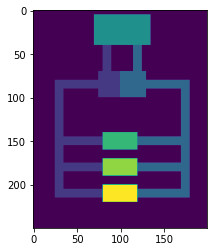

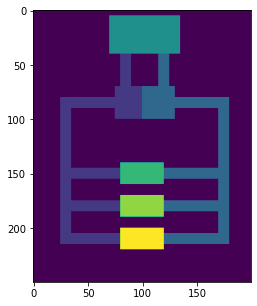

In [40]:
o = oxygen()
o.enter_blood()
plt.imshow(board)

fig, ax = plt.subplots(figsize=(10,5))

for _ in range(400):
  
    '''
    Oxygen Object Movement
    '''
    
    location = o.board_location()
    if location[1] < 85:
        o.movement_down()
        o.draw()
    elif location[0] < 175 and location[1] == 85:
        o.movement_right()
        o.draw()
    elif location[0] == 175 and location[1] < 150: 
        o.movement_down()
        o.draw()
    elif location[0] == 175 and location[1] == 150: #Potentially enter organ 1
        prob = random.random()
        if prob > 0.33:
            o.movement_down()
            o.draw()
        else:
            o.movement_left()
            o.draw()
    elif location[1] == 150:
        d = o.distance(115,150)
        if d < 3:
            del o
        else: 
            o.movement_left()
            o.draw()
    elif location[1] < 180: #Potentially enter organ 2 
            o.movement_down()
            o.draw()
    elif location[0] == 175 and location[1] == 180:
        prob = random.random()
        if prob > 0.33:
            o.movement_down()
            o.draw()
        else:
            o.movement_left()
            o.draw()
    elif location[1] == 180:
        d = o.distance(115,180)
        if d < 3:
            del o
        else: 
            o.movement_left()
            o.draw()
    elif location[1] < 210: #Potentially enter organ 3 
        o.movement_down()
        o.draw()
    elif location[1] == 210:
        d = o.distance(115,210)
        if d < 3:
            del o
        else: 
            o.movement_left()
            o.draw()
    



            
        
            
    
# Animaiton part (dosn't change)
    plt.imshow(board)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.0001)      # Sleep for a fraction of a second to allow animation to catch up
  # Sleep for a fraction of a second to allow animation to catch up

   

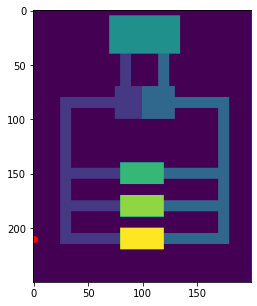

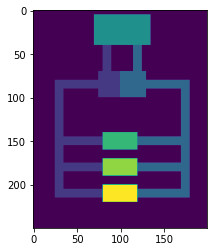

<Figure size 720x360 with 0 Axes>

In [15]:
# blood cell movement
b = blood_cell(120,40)
plt.imshow(board)

fig, ax = plt.subplots(figsize=(10,5))

for _ in range(400):
  
    '''
    Oxygen Object Movement
    '''
    
    location = b.board_location()
    if location[1] < 85:
        b.movement_down()
        b.draw()
    elif location[0] < 175 and location[1] == 85:
        b.movement_right()
        b.draw()
    elif location[0] == 175 and location[1] < 150: 
        b.movement_down()
        b.draw()
    elif location[0] == 175 and location[1] == 150: #Potentially enter organ 1
        prob = random.random()
        if prob > 0.33:
            b.movement_down()
            b.draw()
        else:
            b.movement_left()
            b.draw()
    elif location[1] == 150:
        b.movement_left()
        b.draw()  #### BEGIN NEW MOVEMENT UPWARDS ONCE LOCATION[0] == ~ 25, AND LOCATION[1] == 150
    elif location[1] < 180: #Potentially enter organ 2 
        b.movement_down()
        b.draw()
    elif location[0] == 175 and location[1] == 180:
        prob = random.random()
        if prob > 0.33:
            b.movement_down()
            b.draw()
        else:
            b.movement_left()
            b.draw()
    elif location[1] == 180:
        b.movement_left()
        b.draw()  #### BEGIN NEW MOVEMENT UPWARDS ONCE LOCATION[0] == ~ 25, AND LOCATION[1] == 180
    elif location[1] < 210: #Potentially enter organ 3 
        b.movement_down()
        b.draw()
    elif location[1] == 210:
        b.movement_left()
        b.draw()  #### BEGIN NEW MOVEMENT UPWARDS ONCE LOCATION[0] == ~ 25, AND LOCATION[1] == 210

# Animaiton part (dosn't change)
    plt.imshow(board)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.0001)      # Sleep for a fraction of a second to allow animation to catch up
  # Sleep for a fraction of a second to allow animation to catch up

   